## Name: Rebecca Kahler

Project Title: Heisman Candidate Prospect and Winner Analysis

github repository: https://github.com/rjkahler/rjkahler.github.io

Data Sources so far: https://www.heisman.com/heisman-winners/, https://www.sports-reference.com/

Project goal: To determine if the Heisman winner is the objectively best football player in the nation, and is not some sort of popularity contest. Data will be scraped from sources listed above. In the cell below, I am storing some data sources that I am thinking about using.

In [1]:
#Link we want to be able to scrape depending on the info we want. Hopefully we can do the same function for each
#page. I think it should be possible.
#https://www.sports-reference.com/cfb/years/2023-team-defense.html
#https://www.sports-reference.com/cfb/years/2023-special-teams.html
#https://www.sports-reference.com/cfb/years/2023-ratings.html
#https://www.sports-reference.com/cfb/years/2023-polls.html

#this on would be different and might be uncessecary
#https://www.sports-reference.com/cfb/years/2022-leaders.html

In [2]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import math as m
import numpy as np
import  matplotlib.pyplot as plt
import time
import seaborn as sns

First, I will be scraping the Hiesman website to get the list of winners. I will also be getting a few other attributes like the year (calendar year before the heisman was awarded), School, Position, and (education) Class.

In [3]:
#Using beautiful soup to scrape the heisman website.
winners_web = 'https://www.heisman.com/heisman-winners/'
winners_soup = BeautifulSoup(requests.get(winners_web).text, 'html.parser')

In [4]:
#This cell I grab the header of the html table. This will make up the column names of my dataframe
header = [thing.text for thing in winners_soup.find_all('div', class_ = 'table_headings')[0].find_all('p')][1:]
header

['Player', 'Year', 'School', 'Pos', 'Class']

This next cell contructs the table using .get() to get the text assigned to the given html class-like object under the html tag. I display the tail of the dataframe at the end.

In [5]:
table = winners_soup.find_all('div', class_ = 'table_roster')[0]
winner_rows  = table.find_all('article')
name = []
year = []
school = []
pos = []
class_ = []
for thing in winner_rows:
    
    name.append(thing.get('data-name'))
    year.append(thing.get('data-year'))
    school.append(thing.get('data-school'))
    pos.append(thing.get('data-position'))
    class_.append(thing.get('data-class'))
    
info_dict = dict(zip(header, [name, year, school, pos, class_]))
winners_df = pd.DataFrame.from_dict(info_dict)
winners_df.tail()

,Player,Year,School,Pos,Class
82,Kyler Murray,2018,Oklahoma,QB,Junior*
83,Joe Burrow,2019,LSU,QB,Senior*
84,DeVonta Smith,2020,Alabama,WR,Senior
85,Bryce Young,2021,Alabama,QB,Sophomore
86,Caleb Williams,2022,USC,QB,Sophomore


If you look in the class column, you can see an asterisk. This asterisk represents whether or not the given classification is a redshirt classification or not. I decided to make a redshirtflag column so that I can clearly see the proportion of players that had a redshirt status. The plot is displayed below.

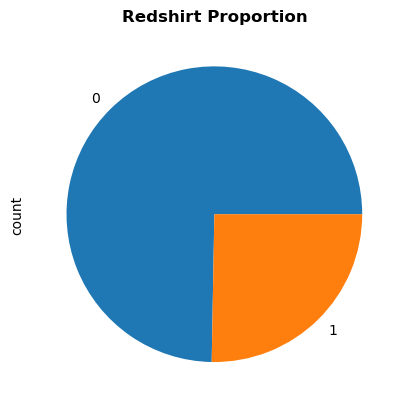

In [6]:
winners_df['redshirt'] = np.where(winners_df['Class'].str.contains('\*') == True,1,0)
winners_df.redshirt.value_counts().plot(kind = 'pie')
plt.title('Redshirt Proportion', fontweight = 'bold')
plt.show()

Only about a quarter of all Heisman winners utilized a redshirt year.

Next, I plot the proportion each position group make up out of the Heisman winners.

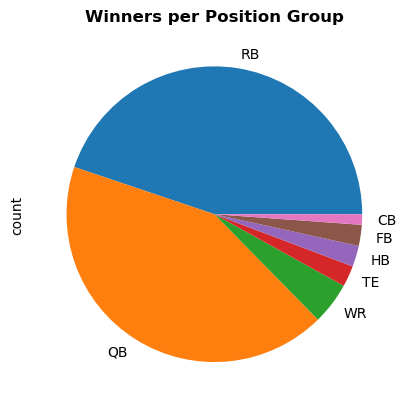

In [7]:
winners_df.Pos.value_counts().plot.pie(normalize = True)
plt.title('Winners per Position Group', fontweight = 'bold')
plt.savefig('winner_per_pos.png')
plt.show()

Quarterback and running back make up most of the Hesiman winners, and it's not particularly close.

Since there are only 87 Heisman winners, I would like to bring in all players who revieved a Heisman ballot. In order to get this info, I make urls from the player names and scrape the resulting webpage. Then I form a ballot_df which has all the players who earned a ballot.

In [8]:
#Taking the hyphens out of the names, then collecting the names
winners_df['player_string'] = winners_df.Player.apply(lambda x: x.replace(' ', '-'))
players = winners_df.player_string.to_list()

#making the urls
player_urls = ['https://www.heisman.com/heisman-winners/' + players[k] + '/' for k in range(0,len(players))]

#these were urls that failed, and the easiest fix was to hard-code them in
bad_url = ['https://www.heisman.com/heisman-winners/6721/','https://www.heisman.com/heisman-winners/davey-obrien/',
          'https://www.heisman.com/heisman-winners/felix-doc-blanchard/']
#their respective indices.
bad_ind = [3,10,67]

#replacing the bad urls with good ones.
for count in range(0,3):
    ind = bad_ind[count]
    player_urls[ind] = bad_url[count]

The next cell requests the webpage, and the cell after that transforms the requests into BeautifulSoup objects. I put these in two different cells so just in case something went wrong the getting the reqests.

In [9]:
player_requests = [requests.get(url) for url in player_urls]

In [10]:
player_soups = [BeautifulSoup(req.text, 'html.parser') for req in player_requests]

This function makes baby ballot dataframes for each year. I then concat the baby ballot dataframes to form the final ballot dataframe. The head of the dataframe is displayed two cells below.

In [11]:
def get_ballot_df(soup):
    table = soup.find_all('table', class_ = 'vote_results_table')[0]
    rows = table.find_all('tr')
    data = [[thing.text for thing in row] for row in rows]
    ballot_df = pd.DataFrame(columns = data[0], data = data[1:])
    year_str = soup.find_all('div',class_ = 'col-xs-12 col-md-8 col-md-push-2 article-col')[0].find_all('p')[0].text.split()[-1]
    year = int(year_str[:-1]) - 1
    ballot_df['year'] = year
    return ballot_df

In [12]:
ballot_df = pd.concat(get_ballot_df(soup) for soup in player_soups)
ballot_df.head()

,,Player,Class,Position,School,Total Points,year,1st,2nd,3rd
0,1,Jay Berwanger,SR,RB,Chicago,84,1934,NaN,NaN,NaN
1,2,Monk Meyer,JR,HB,Army,29,1934,NaN,NaN,NaN
2,3,William Shakespeare,SR,HB,Notre Dame,23,1934,NaN,NaN,NaN
3,4,Pepper Constable,SR,FB,Princeton,20,1934,NaN,NaN,NaN
0,1,Larry Kelley,SR,E,Yale,213,1935,NaN,NaN,NaN


Now that we have more players, I would like to see if the position proportions have changed much

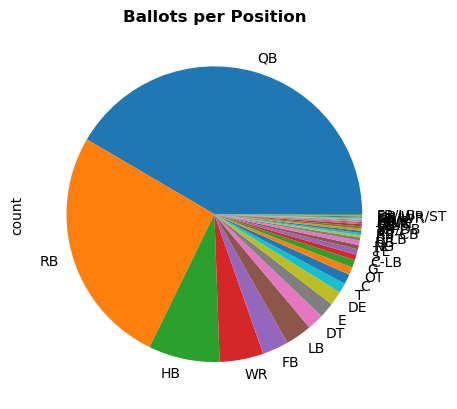

In [13]:
ballot_df.Position.value_counts().plot(kind = 'pie')
plt.title('Ballots per Position', fontweight = 'bold')
plt.show()

QB and RB both still take up a huge proportion overall. The reason for the smaller RB proportion could be because of players who played multiple positions, one of them being running back. See the unique postions for all balloted players:

In [20]:
ballot_df.Position.unique()

array(['RB', 'HB', 'FB', 'E', 'QB', 'T', 'C-LB', 'TB', 'OL', 'C', 'B',
       'LB', 'G', 'C-NG', 'WR', 'G-LB', 'DB', 'TE', 'DE', 'DT', 'C/LB',
       'QB/K', 'NG', 'RB/P', 'RB-CB', 'S', 'OT', 'NT', 'RB/DB', 'CB',
       'CB/WR', 'DB/WR/ST', 'FB/LB'], dtype=object)

Given the evolution of how football is played, I'm interested to know how the positions are with repsect to time. Have quarterbacks and running backs always been so popular, or has this been a recent thing since the football has become more creative with offense the past few decades. After all, defense wins games, but offense brings fans.

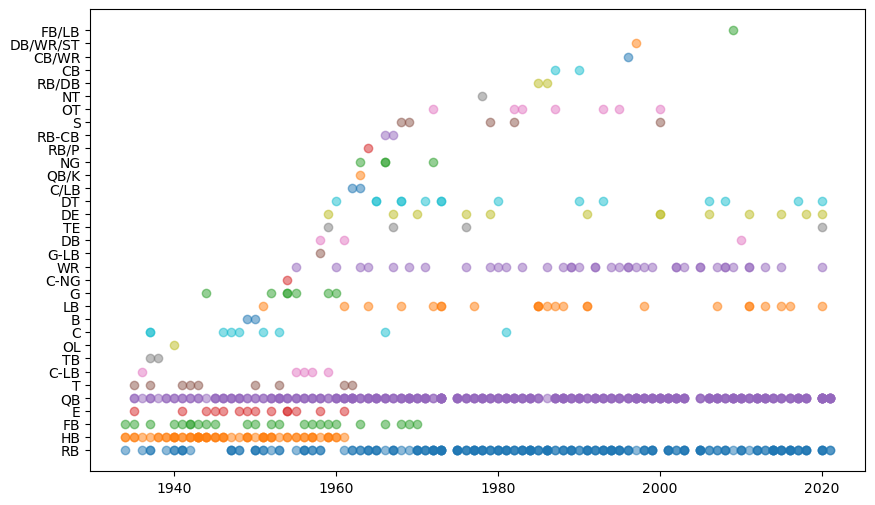

In [58]:
plt.figure(figsize=(10,6))
for pos in ballot_df.Position.unique():
    plot_data = ballot_df.loc[ballot_df['Position']== pos]
    plt.scatter(plot_data.year, plot_data['Position'], alpha = 0.5)
plt.savefig('pos_over_years.png')
plt.show()

It does appear that while quarterbacks and running backs have always been popular, we see more overlap after around 1950. We also see the sparsity of other positions, like halfback and fullback. Is it possible that we just stopped describing what type of backs a player is? (A question I will try to answer)

The cell below is me cleaning the school name column. In a prevous version of my code, this was used and I will be using it again after I decide how to quantify popularity.

In [15]:
winners_df.loc[winners_df['School']== 'lsu', 'School'] = 'louisiana-state'
winners_df.loc[winners_df['School']== 'smu', 'School'] = 'southern-methodist'
winners_df.loc[winners_df['School'] == 'usc', 'School'] = 'southern-california'
winners_df.loc[winners_df['School'] == 'tcs', 'School'] = 'texas-christian' 
winners_df.loc[winners_df['School'] == 'texas-a&m', 'School'] = 'texas-am'
winners_df.loc[winners_df['School']== 'miami-(fla.)', 'School'] = 'miami-fl' 

Now my first goal is to figure out how big of outliers these Heisman candidates and winners are in. comparison to their peers. In order to do this, I will be scraping in passing, rushing, and receiving statistics for all years available, and encompassing all D1 level players. I will then z-score each numerical column, and analyze how many standard deviations away our Heisman level players are.

This cell ceates the urls for each year.

In [17]:
passing_urls = ['https://www.sports-reference.com/cfb/years/' + winners_df['Year'][ind] + '-passing.html' for ind in winners_df.index]
rushing_urls = ['https://www.sports-reference.com/cfb/years/' + winners_df['Year'][ind] + '-rushing.html' for ind in winners_df.index]
rec_urls = ['https://www.sports-reference.com/cfb/years/' + winners_df['Year'][ind] + '-receiving.html' for ind in winners_df.index]

The next three cells get the requests, and then I check to make sure they are valid. As you can see, the requests for years 1935-1955 are not valid. This is because the statistics are not recorded on sports-reference.com. I will be dumping these years since we are in a new era of football. Also, I commented out the lines of code that printed the urls with issues. If you un-comment them, you can see that they print out the same exact years having issues.

In [18]:
pass_request_list = []

for url in passing_urls:
    req = requests.get(url)
    time.sleep(5)
    if req.status_code == 200:
        pass_request_list.append(req)
    else:
        print('Issue with', url)

Issue with https://www.sports-reference.com/cfb/years/1935-passing.html
Issue with https://www.sports-reference.com/cfb/years/1936-passing.html
Issue with https://www.sports-reference.com/cfb/years/1937-passing.html
Issue with https://www.sports-reference.com/cfb/years/1938-passing.html
Issue with https://www.sports-reference.com/cfb/years/1939-passing.html
Issue with https://www.sports-reference.com/cfb/years/1940-passing.html
Issue with https://www.sports-reference.com/cfb/years/1941-passing.html
Issue with https://www.sports-reference.com/cfb/years/1942-passing.html
Issue with https://www.sports-reference.com/cfb/years/1943-passing.html
Issue with https://www.sports-reference.com/cfb/years/1944-passing.html
Issue with https://www.sports-reference.com/cfb/years/1945-passing.html
Issue with https://www.sports-reference.com/cfb/years/1946-passing.html
Issue with https://www.sports-reference.com/cfb/years/1947-passing.html
Issue with https://www.sports-reference.com/cfb/years/1948-passi

In [22]:
rush_request_list = []

for url in rushing_urls:
    req = requests.get(url)
    time.sleep(5)
    if req.status_code == 200:
        rush_request_list.append(req)
#     else:
#         print('Issue with', url)

In [23]:
rec_request_list = []

for url in rec_urls:
    req = requests.get(url)
    time.sleep(5)
    if req.status_code == 200:
        rec_request_list.append(req)
#     else:
#         print('Issue with', url)

This next function is what builds the passing, receiving, and rushing dataframes. This function will also work to build the team-statsitcs dataframe when I need it, as well a poll dataframe which I'm not sure if I will have use for or not. The reason why it's so flexible is because I have dynamically built in the number/names of the columns, so it will work for differnt types of statistics.

df_build builds the dataframe.
fix_name removes the asterisks on player's names which indicates with bowl statistics are included or not. 
get_pos_df takes in the request, and does some cleaning so that I don't have to copy and paste code 20,000 times.

In [24]:
def df_build(soup):
    table = soup.find_all('tbody')[0]
    rows = table.find_all('tr')
    col_names = [thing.get('data-stat') for thing in rows[0].find_all('td')]
    all_row_data = [[thing.text for thing in row.find_all('td')] for row in rows]
    row_data = [list_ for list_ in all_row_data if len(list_) == len(col_names)]

    df = pd.DataFrame(columns = col_names, data = row_data)
    web_head = soup.find_all('h1')[0].text.split()
    df['year'] = web_head[0].strip()
    df['stat_type'] = web_head[-2]
    return df

def fix_name(name):
    split = name.split("*")
    return split[0].strip()

def get_pos_df(req_list):
    soups = [BeautifulSoup(req.text, 'html.parser') for req in req_list]
    df = pd.concat([df_build(soup) for soup in soups])
    cols = df.columns[3:-1].to_list()
    
    #Fills missing numerical data with zero
    df[cols] = df[cols].replace('',0)
    #transfroms numerical data to the desired datatype
    df[cols] = df[cols].astype(float)
    
    #making the flag column to track if player's statistics include the bowl game
    df['bowl_flag'] = np.where(df['player'].str.contains('\*') == True,1,0)
    #getting rid of the asterirsk so that I can deal with the players names much more easily
    df.player = df['player'].apply(lambda x: fix_name(x))
    return df

Because everthing is nice and compact in this function, I just need to make the dataframes. This next cell takes a little bit because of all the heavy lifting the function does..

In [25]:
pass_df = get_pos_df(pass_request_list)
rush_df = get_pos_df(rush_request_list)
rec_df = get_pos_df(rec_request_list)

Now we can see the tail of each dataframe, summary stats,and ensure that the function changed the datatypes as it should have.

In [26]:
pos_df_list = [pass_df, rush_df, rec_df]

for df in pos_df_list:
    display(df.tail())
    display(df.describe())
    display(df.info())

,player,school_name,conf_abbr,g,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,pass_td,pass_int,pass_rating,rush_att,rush_yds,rush_yds_per_att,rush_td,year,stat_type,bowl_flag
103,John Paddock,Ball State,MAC,12.0,286.0,480.0,59.6,2719.0,5.7,5.1,18.0,14.0,113.7,27.0,-84.0,-3.1,0.0,2022.0,Passing,0
104,Andrew Peasley,Wyoming,MWC,12.0,144.0,275.0,52.4,1574.0,5.7,5.0,10.0,9.0,105.9,81.0,339.0,4.2,2.0,2022.0,Passing,1
105,Grayson James,Florida International,CUSA,11.0,210.0,358.0,58.7,1969.0,5.5,4.7,11.0,11.0,108.9,79.0,223.0,2.8,3.0,2022.0,Passing,0
106,Zion Turner,Connecticut,Ind,13.0,149.0,258.0,57.8,1407.0,5.5,4.4,9.0,10.0,107.3,90.0,262.0,2.9,1.0,2022.0,Passing,1
107,Connor Bazelak,Indiana,Big Ten,10.0,235.0,426.0,55.2,2312.0,5.4,5.0,13.0,10.0,106.1,47.0,-160.0,-3.4,1.0,2022.0,Passing,0


,g,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,pass_td,pass_int,pass_rating,rush_att,rush_yds,rush_yds_per_att,rush_td,year,bowl_flag
count,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000
mean,11.137911,167.491442,293.485540,55.881330,2107.000197,7.081959,6.263112,14.344678,10.621090,123.077848,78.254377,119.064135,0.672831,3.039150,1995.049970,0.236868
std,1.314731,68.482572,96.159096,6.845066,840.531873,1.106591,1.882334,8.268399,4.225683,21.598600,40.354173,255.004076,2.550774,3.144782,17.485449,0.425202
min,2.000000,23.000000,49.000000,26.200000,328.000000,3.100000,-1.500000,0.000000,0.000000,0.000000,0.000000,-415.000000,-9.400000,0.000000,1956.000000,0.000000
25%,10.000000,112.000000,215.000000,51.200000,1444.000000,6.300000,5.100000,8.000000,8.000000,108.900000,48.000000,-54.000000,-1.100000,1.000000,1981.000000,0.000000
50%,11.000000,155.000000,280.000000,56.200000,1971.000000,7.000000,6.300000,13.000000,10.000000,123.000000,70.000000,49.000000,0.800000,2.000000,1997.000000,0.000000
75%,12.000000,211.000000,358.000000,60.700000,2628.500000,7.800000,7.500000,19.000000,13.000000,137.400000,99.000000,235.500000,2.600000,4.000000,2010.000000,0.000000
max,16.000000,512.000000,719.000000,77.400000,5967.000000,11.900000,13.600000,62.000000,34.000000,207.600000,317.000000,1920.000000,8.200000,27.000000,2022.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 5083 entries, 0 to 107
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   player                5083 non-null   object 
 1   school_name           5083 non-null   object 
 2   conf_abbr             5083 non-null   object 
 3   g                     5083 non-null   float64
 4   pass_cmp              5083 non-null   float64
 5   pass_att              5083 non-null   float64
 6   pass_cmp_pct          5083 non-null   float64
 7   pass_yds              5083 non-null   float64
 8   pass_yds_per_att      5083 non-null   float64
 9   adj_pass_yds_per_att  5083 non-null   float64
 10  pass_td               5083 non-null   float64
 11  pass_int              5083 non-null   float64
 12  pass_rating           5083 non-null   float64
 13  rush_att              5083 non-null   float64
 14  rush_yds              5083 non-null   float64
 15  rush_yds_per_att      5083 

None

,player,school_name,conf_abbr,g,rush_att,rush_yds,rush_yds_per_att,rush_td,rec,rec_yds,rec_yds_per_rec,rec_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,year,stat_type,bowl_flag
278,Hunter Dekkers,Iowa State,Big 12,12.0,89.0,73.0,0.8,2.0,0.0,0.0,0.0,0.0,89.0,73.0,0.8,2.0,2022.0,Rushing,0
279,Taulia Tagovailoa,Maryland,Big Ten,12.0,87.0,64.0,0.7,4.0,0.0,0.0,0.0,0.0,87.0,64.0,0.7,4.0,2022.0,Rushing,1
280,Cameron Ward,Washington State,Pac-12,13.0,107.0,58.0,0.5,5.0,1.0,-13.0,-13.0,0.0,108.0,45.0,0.4,5.0,2022.0,Rushing,1
281,Chase Cunningham,Middle Tennessee State,CUSA,12.0,99.0,52.0,0.5,6.0,1.0,-1.0,-1.0,0.0,100.0,51.0,0.5,6.0,2022.0,Rushing,1
282,Clay Millen,Colorado State,MWC,10.0,100.0,-28.0,-0.3,0.0,1.0,16.0,16.0,0.0,101.0,-12.0,-0.1,0.0,2022.0,Rushing,0


,g,rush_att,rush_yds,rush_yds_per_att,rush_td,rec,rec_yds,rec_yds_per_rec,rec_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,year,bowl_flag
count,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000,19527.000000
mean,10.731295,125.894249,549.100220,4.175009,5.031444,9.076458,83.895580,7.372407,0.465458,134.970707,632.995801,4.474871,5.496902,1987.403749,0.158242
std,1.356679,53.227044,339.897002,1.523608,4.080346,10.334642,101.508772,6.381899,0.901489,57.602547,388.817167,1.642511,4.312296,19.195193,0.364978
min,1.000000,14.000000,-415.000000,-5.900000,0.000000,0.000000,-25.000000,-25.000000,0.000000,14.000000,-415.000000,-5.900000,0.000000,1956.000000,0.000000
25%,10.000000,86.000000,326.000000,3.600000,2.000000,1.000000,4.000000,2.000000,0.000000,92.000000,374.000000,3.900000,2.000000,1972.000000,0.000000
50%,11.000000,111.000000,479.000000,4.300000,4.000000,6.000000,51.000000,7.400000,0.000000,119.000000,561.000000,4.700000,5.000000,1985.000000,0.000000
75%,11.000000,152.000000,711.000000,5.100000,7.000000,14.000000,125.000000,10.500000,1.000000,163.000000,830.000000,5.400000,7.000000,2004.000000,0.000000
max,16.000000,450.000000,2628.000000,10.100000,37.000000,99.000000,1099.000000,87.000000,9.000000,474.000000,2809.000000,11.900000,39.000000,2022.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 19527 entries, 0 to 282
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             19527 non-null  object 
 1   school_name        19527 non-null  object 
 2   conf_abbr          19527 non-null  object 
 3   g                  19527 non-null  float64
 4   rush_att           19527 non-null  float64
 5   rush_yds           19527 non-null  float64
 6   rush_yds_per_att   19527 non-null  float64
 7   rush_td            19527 non-null  float64
 8   rec                19527 non-null  float64
 9   rec_yds            19527 non-null  float64
 10  rec_yds_per_rec    19527 non-null  float64
 11  rec_td             19527 non-null  float64
 12  scrim_att          19527 non-null  float64
 13  scrim_yds          19527 non-null  float64
 14  scrim_yds_per_att  19527 non-null  float64
 15  scrim_td           19527 non-null  float64
 16  year               19527 non-

None

,player,school_name,conf_abbr,g,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,year,stat_type,bowl_flag
471,Carson Steele,Ball State,MAC,12.0,29.0,166.0,5.7,1.0,289.0,1556.0,5.4,14.0,318.0,1722.0,5.4,15.0,2022.0,Receiving,0
472,Kairee Robinson,San Jose State,MWC,12.0,26.0,144.0,5.5,0.0,157.0,752.0,4.8,10.0,183.0,896.0,4.9,10.0,2022.0,Receiving,1
473,Devon Achane,Texas A&M,SEC,10.0,36.0,196.0,5.4,3.0,196.0,1102.0,5.6,8.0,232.0,1298.0,5.6,11.0,2022.0,Receiving,0
474,Aidan Robbins,UNLV,MWC,11.0,23.0,125.0,5.4,1.0,209.0,1009.0,4.8,9.0,232.0,1134.0,4.9,10.0,2022.0,Receiving,0
475,Clyde Price,Akron,MAC,12.0,31.0,139.0,4.5,1.0,99.0,309.0,3.1,7.0,130.0,448.0,3.4,8.0,2022.0,Receiving,0


,g,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,year,bowl_flag
count,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000,18883.00000,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000,18883.000000
mean,11.165016,37.713605,503.843722,13.286734,3.479797,22.316793,109.19875,2.728645,0.957157,60.030398,613.042472,12.410385,4.436954,1996.964730,0.257957
std,1.440664,16.110838,254.135954,3.495118,2.927676,55.913353,279.07691,5.187177,2.782406,56.104598,321.786267,4.013557,3.653888,17.429387,0.437522
min,0.000000,4.000000,7.000000,1.400000,0.000000,0.000000,-129.00000,-40.000000,0.000000,4.000000,28.000000,3.000000,0.000000,1956.000000,0.000000
25%,11.000000,26.000000,322.000000,11.000000,1.000000,0.000000,0.00000,0.000000,0.000000,29.000000,385.000000,10.100000,2.000000,1983.000000,0.000000
50%,11.000000,33.000000,444.000000,13.100000,3.000000,1.000000,0.00000,0.000000,0.000000,40.000000,530.000000,12.600000,4.000000,1999.000000,0.000000
75%,12.000000,45.000000,627.000000,15.500000,5.000000,6.000000,37.00000,4.800000,0.000000,61.000000,754.000000,15.000000,6.000000,2012.000000,1.000000
max,15.000000,158.000000,2060.000000,31.900000,27.000000,403.000000,2342.00000,77.000000,28.000000,432.000000,2664.000000,30.100000,32.000000,2022.000000,1.000000


<class 'pandas.core.frame.DataFrame'>
Index: 18883 entries, 0 to 475
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   player             18883 non-null  object 
 1   school_name        18883 non-null  object 
 2   conf_abbr          18883 non-null  object 
 3   g                  18883 non-null  float64
 4   rec                18883 non-null  float64
 5   rec_yds            18883 non-null  float64
 6   rec_yds_per_rec    18883 non-null  float64
 7   rec_td             18883 non-null  float64
 8   rush_att           18883 non-null  float64
 9   rush_yds           18883 non-null  float64
 10  rush_yds_per_att   18883 non-null  float64
 11  rush_td            18883 non-null  float64
 12  scrim_att          18883 non-null  float64
 13  scrim_yds          18883 non-null  float64
 14  scrim_yds_per_att  18883 non-null  float64
 15  scrim_td           18883 non-null  float64
 16  year               18883 non-

None

Here is where I am stuck because when I tried to normalize (z-score) each column based on the year, my computer did not like it and freaked out, so I'm assuming the code is widly inefficient. I will plot an example of what I would like to do on a much larger scale. 


After I get this data normalized how I would like I will run a hypothesis test to see if the winners (or balloted players) are indeed statistically significant. 

As far as measuring popularity is concerned: I'm a little bit worried about scraping headlines for reasons which I will explain in my presentation, but I would like to use team-statistics to see if I can find some sort of markovian structure I could exploit, i.e. see if I can find the expected Heisman frontrunner of a position group based solely on past data (and then maybe I can see if there has been some recent helmet bias). 

In [33]:
# for year in pass_df.year:
#     filtered_df = pass_df.loc[pass_df['year']== year]
#     for col in pass_df.columns[4:-3]:
#         col_name = 'normal' + f'{col}'
#         filtered_df[col_name] = (filtered_df[col]-filtered_df[col].mean())/filtered_df[col].std()

# def get_normal_df(df):
#     first_cols = df.cols[:3]
#     normal_df = df[]


In [46]:
sub_df = rush_df.loc[rush_df['year']==2021]

If we look at the rushers from the year 2021, normalize the columns for number of rushing touchdowns, and number of rushing yards per attempts, then we highlight the two Heisman candidates, we can see where they fall in compared to their peers.

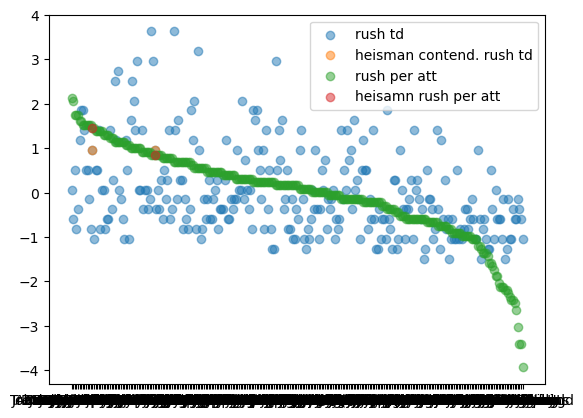

In [59]:
n_rush_td = (sub_df.rush_td - sub_df.rush_td.mean())/sub_df.rush_td.std()
n_rypa = (sub_df.rush_yds_per_att - sub_df.rush_yds_per_att.mean())/sub_df.rush_yds_per_att.std()
plot_df = sub_df.loc[(sub_df.index ==13) | (sub_df.index==52)]
plt.scatter(sub_df.player,n_rush_td, label = 'rush td', alpha = 0.5)
plt.scatter(plot_df.player, [n_rush_td[13],n_rush_td[52]], label = 'heisman contend. rush td', alpha = 0.5)
plt.scatter(sub_df.player,n_rypa, label = 'rush per att', alpha = 0.5)
plt.scatter(plot_df.player, [n_rypa[13],n_rypa[52]],label = 'heisamn rush per att', alpha = 0.5)
plt.legend()
plt.savefig('st_dev_plot_ex.png')
plt.show()

For rushing touchdowns, they are both about 1 standard devaition away from the mean for the year 2021. For reference, the two candidates has 24 and 26 rushing tds. As for rushing yards per attempt, we do have more separation between the two candidates. One is more than one standard devitation away from the mean, while the other is less than one standard deviation away from the mean.